## Gray Wolf optimization for Travelling Salesman Problem

In [222]:
import numpy as np
import matplotlib.pyplot as plt
import math
import copy
import random
import networkx as nx

In [226]:
def plots(data,x_label,y_label,title):
    plt.plot(data)
    plt.grid(True)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

In [216]:
#Fuente Chat GPT
def plotting(cities,paths):    
    G = nx.complete_graph(cities)  

    edge_colors = {}
    color_map = ['r', 'g', 'b', 'c', 'm', 'y']

    for i, p in enumerate(paths):
        color = color_map[i % len(color_map)]
        for j in range(len(p) - 1):
            edge = (p[j], p[j + 1])
            edge_colors[edge] = color

    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='k', font_color='w')

    for edge, color in edge_colors.items():
        nx.draw_networkx_edges(G, pos, edgelist=[edge], edge_color=color)

    legend_labels = [f'Path {i+1}' for i in range(len(paths))]
    legend_colors = color_map[:len(paths)]
    legend_handles = [plt.Line2D([0], [0], color=color, label=label) for label, color in zip(legend_labels, legend_colors)]
    plt.legend(handles=legend_handles, loc='upper left')

    plt.show()

In [2]:
class PriorityQueue(object):
    """
    Implementation of the queue data structure
    """
    def __init__(self):
        self.l = 0
        self.queue = []      
    
    def enqueue(self, item):
        """
        Add new item to the queue
        """
        
        self.queue.append(item)
        self.l += 1
        j = self.l - 2
        while (j >= 0) and (item[1] < self.queue[j][1]):
            self.queue[j+1] = self.queue[j]
            j -= 1
        self.queue[j+1] = item    
        
    def dequeue(self):
        """
        Remove item with lowest key
        """
        x = self.queue.pop(0)
        self.l -= 1
        return x

In [3]:
def is_in_list(number,list):
    for i in list:
        if number == i:
            return True
    return False

In [4]:
def wolf_TSMP_population(N,cities):
    wolves = []
    wolf = []
    for i in range(N):
        wolf = [0]
        while len(wolf) != cities:
            temp_city = random.randint(1,cities-1)
            if not is_in_list(temp_city,wolf):
                wolf.append(temp_city)
        wolves.append(wolf)   
    return wolves

In [10]:
def distances(cities,ranges):
    distance_matrix = np.zeros([cities,cities])
    for i in range(cities):
        for j in range(cities):
            if i != j:
                distance_matrix[i][j] = random.randint(ranges[0],ranges[1])
            else:
                distance_matrix[i][j] = 0
    return distance_matrix

In [201]:
def distance_calculation(wolf,distances):
    distance = 0
    for i in range(len(wolf)):
        if i+1 < len(wolf):
            city_a = wolf[i]
            city_b = wolf[i+1]
            distance += distances[city_a][city_b]
        else:
            city_a = wolf[i]
            city_b = 0
            distance += distances[city_a][city_b]
            break
    return distance

In [202]:
def wolves_fitness(wolves,distances):
    fitted_wolves = PriorityQueue()
    for wolf in wolves:
        distance = distance_calculation(wolf,distances)
        fitted_wolves.enqueue([wolf,distance])
    return fitted_wolves    

In [204]:
def elite_wolves(wolves_fitted):
    alpha = wolves_fitted.dequeue()[0]
    beta = wolves_fitted.dequeue()[0]
    delta = wolves_fitted.dequeue()[0]
    rest = []
    for wolf in wolves_fitted.queue:
        rest.append(wolf[0])
    return [alpha,beta,delta,rest]

In [205]:
def humming_distance(wolf1, wolf2):     #Heuristic that indicates the number of different tiles of two arrays given
    diff_wolf = wolf1 - wolf2
    hm_distance = 0
    for i in range(len(diff_wolf)):
        if diff_wolf[i] != 0:
            hm_distance += 1
    return hm_distance

In [211]:
def two_opt_algo(wolf, distance_matrix,excecs):
    test_wolf = copy.deepcopy(wolf)
    unvisited = test_wolf[1:]
    for i in range(excecs):
        distance_wolf = distance_calculation(test_wolf,distance_matrix)
        city1 = random.choice(unvisited)
        unvisited.pop(unvisited.index(city1))
        city2 = random.choice(unvisited)

        next_wolf = copy.deepcopy(test_wolf)
        next_wolf[test_wolf.index(city1)] = city2
        next_wolf[test_wolf.index(city2)] = city1
        distance_next_wolf = distance_calculation(next_wolf,distance_matrix)

        if (distance_next_wolf <= distance_wolf):
            test_wolf = next_wolf     
        unvisited.append(city1)
                   
    return test_wolf

In [212]:
def update_position(wolf,alpha,beta,delta,distance_matrix):
    d_alpha = random.randint(0,humming_distance(wolf,alpha))
    d_beta = random.randint(0,humming_distance(wolf,beta))
    d_delta = random.randint(0,humming_distance(wolf,delta))

    wolf = wolf.tolist()
    new_wolfs = []
    new = None

    new_wolfs.append(two_opt_algo(wolf,distance_matrix,d_alpha))
    new_wolfs.append(two_opt_algo(wolf,distance_matrix,d_beta))
    new_wolfs.append(two_opt_algo(wolf,distance_matrix,d_delta))

    new_wolfs.append(new)
    distancias = []
    
    for i in range(3):
        distancias.append(distance_calculation(new_wolfs[i],distance_matrix))
    
    min_index = distancias.index(min(distancias))
    return new_wolfs[min_index]

In [218]:
def GWO(wolves_num, cities, distance_ranges, epochs):
    wolves = wolf_TSMP_population(wolves_num, cities)    #Initailization of population
    distance_matrix = distances(cities, distance_ranges)    #Calculate the fitness
    wolves_fitted = wolves_fitness(wolves, distance_matrix)     #Fitted wolves
    elite = elite_wolves(wolves_fitted)     #Elitism
    best_epoch = []
    best_epoch.append(wolves_fitted.queue[0])
    for epoch in range(epochs):
        alpha = np.array(elite[0])
        beta = np.array(elite[1])
        delta = np.array(elite[2])
        omega = elite[3]
        new_wolves = []
        for wolf in omega:
            new_wolves.append(update_position(np.array(wolf),alpha,beta,delta,distance_matrix))
        
        new_wolves.append(elite[0])
        new_wolves.append(elite[1])
        new_wolves.append(elite[2])

        wolves_fitted = wolves_fitness(new_wolves,distance_matrix)
        elite = elite_wolves(wolves_fitted)
        best_epoch.append(wolves_fitted.queue[0])
    return best_epoch

Path inicial: [0, 55, 90, 30, 99, 13, 40, 29, 14, 82, 10, 38, 80, 76, 58, 12, 51, 48, 45, 20, 95, 89, 26, 97, 2, 37, 93, 84, 77, 47, 31, 98, 11, 15, 35, 3, 59, 41, 91, 72, 25, 73, 39, 18, 34, 43, 33, 88, 81, 85, 60, 1, 70, 24, 5, 96, 66, 57, 42, 71, 87, 62, 52, 68, 16, 78, 4, 49, 83, 64, 94, 61, 44, 53, 28, 6, 92, 86, 27, 54, 21, 69, 9, 75, 7, 63, 50, 23, 74, 8, 46, 67, 22, 56, 32, 17, 65, 19, 79, 36], cost of: 456.0
Path final: [0, 32, 89, 66, 54, 98, 93, 11, 7, 41, 86, 3, 67, 76, 85, 79, 90, 48, 45, 37, 95, 72, 31, 16, 78, 20, 12, 59, 96, 83, 70, 33, 35, 24, 23, 38, 74, 82, 17, 73, 47, 44, 39, 18, 30, 52, 57, 5, 58, 60, 43, 1, 6, 13, 40, 77, 91, 99, 68, 65, 4, 22, 26, 2, 8, 56, 28, 15, 51, 64, 94, 61, 49, 53, 81, 87, 80, 21, 92, 27, 63, 88, 9, 75, 34, 25, 50, 42, 97, 69, 46, 10, 62, 36, 55, 71, 84, 19, 29, 14], cost of: 136.0


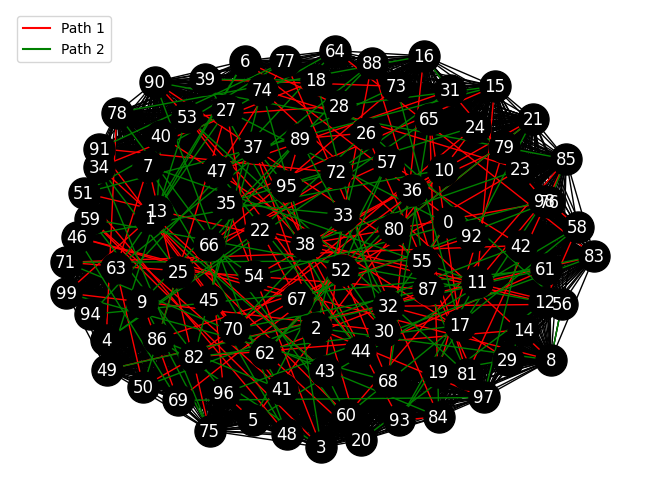

In [228]:
N = 100
cities = 100
epochs = 100
distance_ranges = [1,9]
solution = GWO(N,cities,distance_ranges,epochs)

min_value = []
path = []
for i in solution: path.append(i[0]),min_value.append(i[1])
print("Path inicial: " + str(path[0]) +", cost of: " + str(min_value[0]))
print("Path final: " + str(path[len(path)-1]) +", cost of: " + str(min_value[len(min_value)-1]))
plotting(cities,[path[0],path[len(path)-1]])

Initial cost: 456.0
Final cost: 136.0


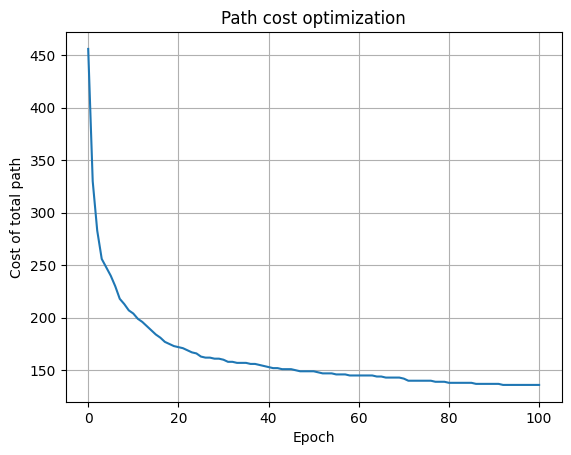

In [229]:
plots(min_value,'Epoch','Cost of total path','Path cost optimization')
print("Initial cost: " + str(min_value[0]))
print("Final cost: " + str(min_value[len(min_value)-1]))

Reference:

Karuna Panwar, Kusum Deep (2021) Discrete Grey Wolf Optimizer for symmetric travelling salesman problem. Applied Soft Computing vol 105. Science Direct.